In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
#Importing all the libraries 
import warnings  #Warning messages are typically issued in situations where it is useful to alert the user of some condition in a program
import matplotlib.pyplot as plt #It allows you to generate high quality line plots, scatter plots, histograms, bar charts, and much more..
import seaborn as sns #The seaborn package was developed based on the Matplotlib library. It is used to create more attractive and informative statistical graphics. 
import numpy as np #NumPy, which stands for Numerical Python, is a library consisting of multidimensional array objects and a collection of routines for processing those arrays.
import pandas as pd #Pandas is just a library of python used for data manipulation and analysis
import re # Regular Expression (RegEx) is a sequence of characters that defines a search pattern
import nltk #NLTK helps the computer to analysis, preprocess, and understand the written text.
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

[nltk_data] Downloading package stopwords to /home/douha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/douha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
#Loading data
data = pd.read_csv("/home/douha/Downloads/bigdata-project1/spam_or_ham/spam.csv")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# Dropping the redundent looking collumans (for this project)
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
data = data.drop(data[to_drop], axis=1)
# Renaming the columns because I feel fancy today 
data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Text(0, 0.5, 'Number of Data points')

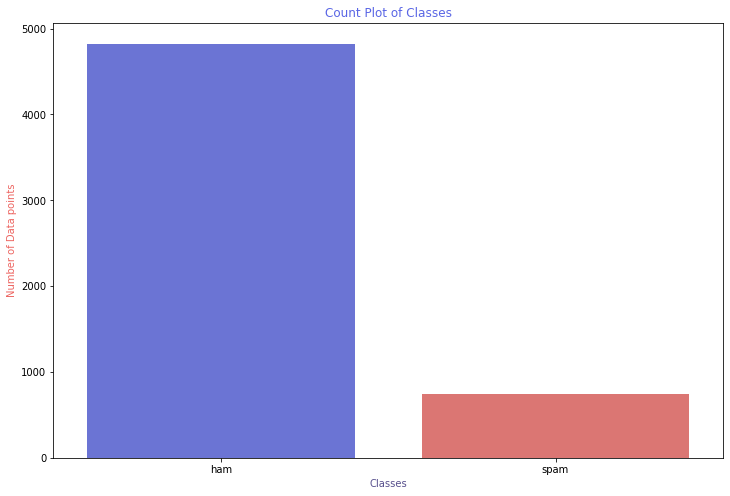

In [6]:
#Palette
cols= ["#5A66E5", "#ED6561"] 
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data["Target"], palette= cols)
fg.set_title("Count Plot of Classes", color="#5A66e5")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#ED6561")

In [7]:
#Adding a column of numbers of charachters,words and sentences in each msg
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

data.describe().T

#PS. At this step, I tokenised the words and sentences and used the length of the same. 
#More on Tokenizing later in the notebook.

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.058686,59.624385,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.777459,13.772819,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,1.993180,1.503525,1.0,1.0,2.0,2.0,38.0


In [8]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/douha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<Figure size 864x576 with 0 Axes>

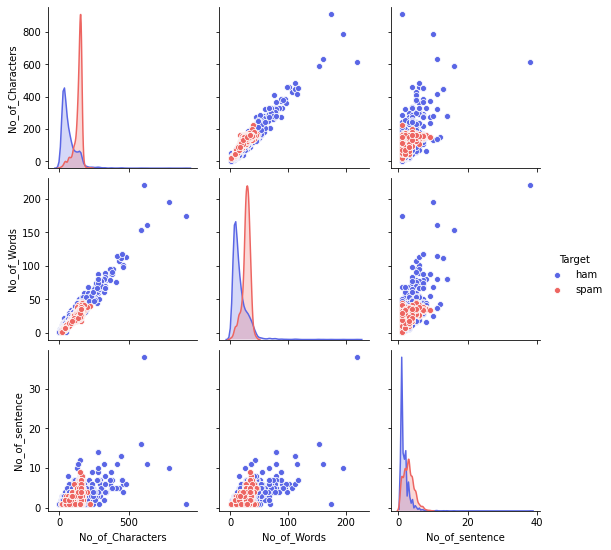

In [9]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)



In [10]:
#Dropping the outliers. 
data = data[(data["No_of_Characters"]<350)]
data.shape

(5548, 5)

<Figure size 864x576 with 0 Axes>

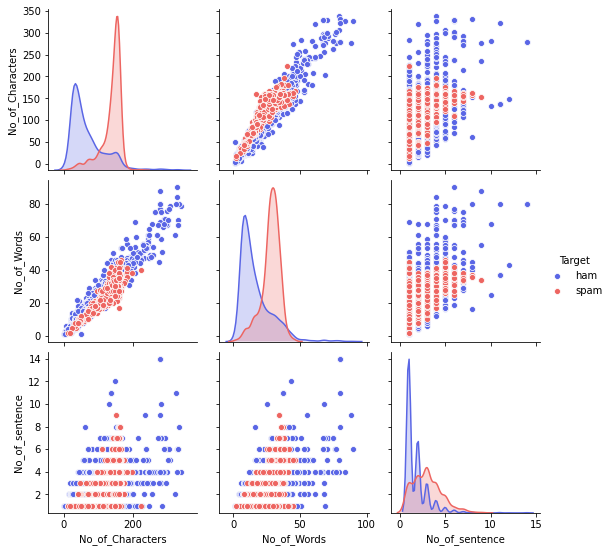

In [11]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

In [12]:
#Lets have a look at a sample of texts before cleaning
print("\033[1m\u001b[45;1m The First 5 Texts:\033[0m",*data["Text"][:5], sep = "\n")



 The First 5 Texts:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


In [13]:
# Defining a function to clean up the text
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["Text"].apply(Clean)
#Lets have a look at a sample of texts after cleaning
print("\033[1m\u001b[45;1m The First 5 Texts after cleaning:\033[0m",*data["Clean_Text"][:5], sep = "\n")

 The First 5 Texts after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


In [14]:
#TOKENIZATION ; is breaking complex data into smaller units called tokens. It can be done by splitting paragraphs into sentences and sentences into words. I am splitting the Clean_Text into words at this step.
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*data["Tokenize_Text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


In [15]:

# Removing the stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*data["Nostopword_Text"][:5], sep = "\n")


 The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


**Stemming** is the process of getting the root form of a word. Stem or root is the part to which inflectional affixes are added. The stem of a word is created by removing the prefix or suffix of a word. It goes back to the etymology of the word. Languages evolve over time. Many different languages branch into each other; for example, English is a derivative of Latin. Thus, stemming a word takes it back to the root word.

**lemmatization** also converts a word to its root form. However, the difference is that lemmatization ensures that the root word belongs to the language one is dealing with, in our case it is English. If we use lemmatization the output would be in English


In [16]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*data["Lemmatized_Text"][:5], sep = "\n")

 The First 5 Texts after lemitization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


# VECTORIZE

**TF-IDF** in NLP stands for Term Frequency – Inverse document frequency. In NLP cleaned data needs to be converted into a numerical format where each word is represented by a matrix. This is also known as word embedding or Word vectorization.

**Term Frequency (TF)** = (Frequency of a term in the document)/(Total number of terms in documents) Inverse Document **Frequency(IDF)** = log( (total number of documents)/(number of documents with term t)) I will be using TfidfVectorizer() to vectorize the preprocessed data.

**Steps in the Vectorizing:**

*     Creating a corpus of lemmatized text
*     Converting the corpus in vector form
*     Label Encoding the classes in Target


In [17]:
#Creating a corpus of text feature to encode further into vectorized form
corpus= []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]
print("The First 5 lines in corpus=",*corpus[:5], sep = "\n")

The First 5 lines in corpus=
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


In [18]:
#Changing text data in to numbers. 
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's have a look at our feature 
X.dtype



dtype('float64')

In [19]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

# MODEL BUILDING

**Steps involved in the Model Building
**
*     Setting up features and target as X and y
*     Splitting the testing and training sets
*     Build a pipeline of model for four different classifiers.
        Naïve Bayes
        RandomForestClassifier
        KNeighborsClassifier
        Support Vector Machines
*     Fit all the models on training data
*     Get the cross-validation on the training set for all the models for accuracy

In [20]:
#Setting values for labels and feature as y and X(we already did X in vectorizing...)
y = data["Target"] 
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
#Testing on the following classifiers
classifiers = [MultinomialNB(), 
               RandomForestClassifier(),
               KNeighborsClassifier(), 
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}



In [22]:
# Cossvalidation 
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))


NaiveBayes: 0.967552 
RandomForest: 0.973861 
KNeighbours: 0.911450 
SVC: 0.974086 


# EVALUATING MODELS

**Testing the models on Testset
**
*     Accuracy Report
*     Confusion Matrix

In [23]:
# Model Evaluation
# creating lists of varios scoresMODELS
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)
  
    #Appending scores
    precision.append(prec)
    recall.append(recal)  
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)


In [24]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC"])

In [25]:
cmap1 = ListedColormap(["#FFCCD6","#CCFAFF"])
Results.style.background_gradient(cmap=cmap1)


,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,1,0.705882,0.827586,0.974775,0.997521
RandomForest,1,0.823529,0.903226,0.974775,0.997521
KNeighbours,0.977778,0.323529,0.486188,0.974775,0.997521
SVC,0.990909,0.801471,0.886179,0.974775,0.997521


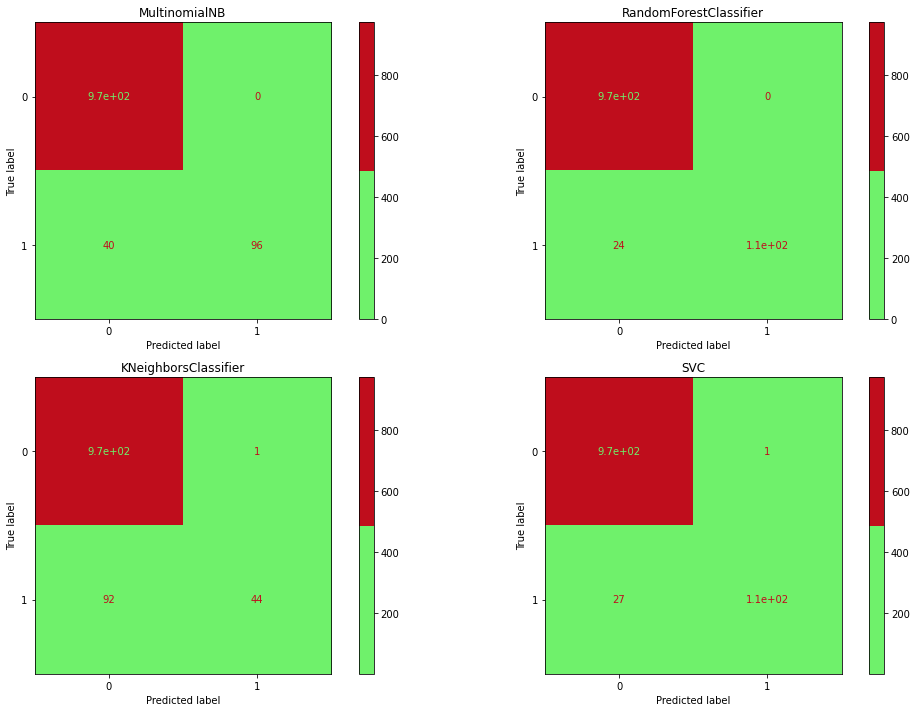

In [27]:
cmap = ListedColormap(["#6ff16b", "#bf0d1c"])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap= cmap,   
                          )
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()